In [67]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import open3d as o3d


LẤY BOUNDING BOX ĐÃ DETECT = YOLO

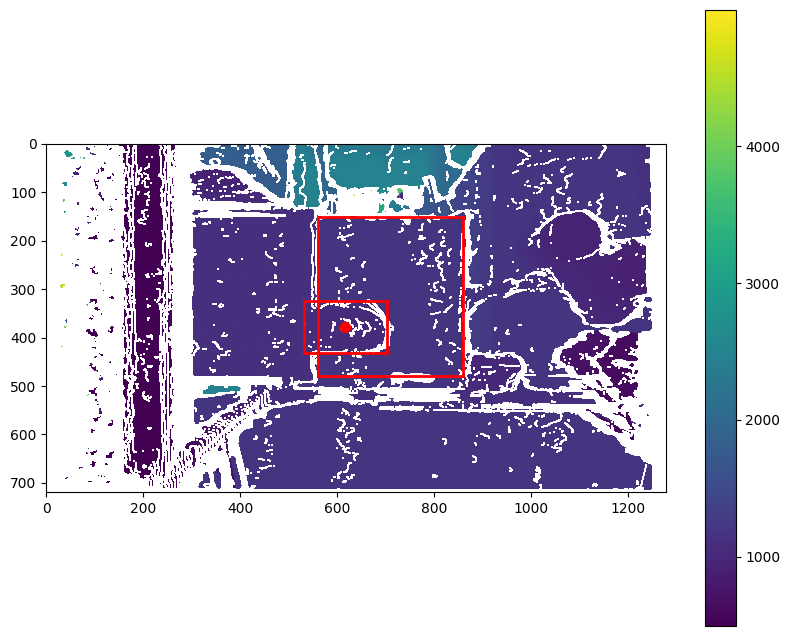

In [63]:
depth = cv2.imread("train/depth/0000.png", cv2.IMREAD_UNCHANGED)
valid_mask = (depth > 0) & (depth < 5000)
depth_disp = np.where(valid_mask, depth, np.nan)

roi_x, roi_y, roi_w, roi_h = 560, 150, 300, 330
box_x_min, box_x_max, box_y_min, box_y_max = 532, 703, 325, 432

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(depth_disp, cmap='viridis')

rect = patches.Rectangle((roi_x, roi_y), roi_w, roi_h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect2 = patches.Rectangle((box_x_min, box_y_min), box_x_max-box_x_min, box_y_max-box_y_min, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

ax.scatter(617.5, 378.5, c='r', s=50) # thử vẽ tâm

plt.colorbar(im)
plt.show()


In [64]:
bounding_box_z = depth[box_y_min:box_y_max+1, box_x_min:box_x_max+1]
bounding_box_z

array([[1126, 1125, 1125, ..., 1197, 1197, 1195],
       [1125, 1125, 1124, ..., 1197, 1197, 1197],
       [1125, 1124, 1123, ..., 1198, 1197, 1197],
       ...,
       [1133, 1132, 1132, ..., 1195, 1196, 1197],
       [1133, 1133, 1132, ..., 1196, 1197, 1199],
       [1132, 1132, 1131, ..., 1197, 1198, 1200]], dtype=uint16)

[55 59 59]


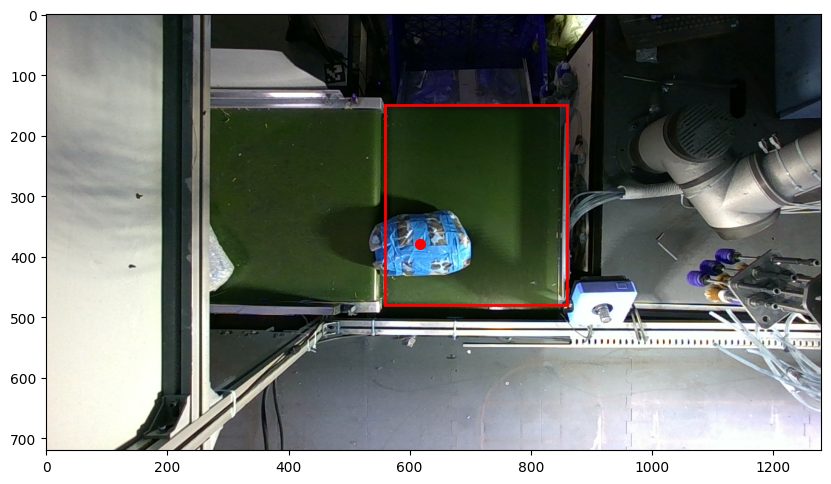

In [65]:
img = cv2.imread("train/rgb/0000.png", cv2.IMREAD_UNCHANGED)
img.shape

print(img[int(617.5), int(378.5)])

roi_x, roi_y, roi_w, roi_h = 560, 150, 300, 330

fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(img)

rect = patches.Rectangle((roi_x, roi_y), roi_w, roi_h, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

ax.scatter(617.5, 378.5, c='r', s=50)


plt.show()

In [66]:
bounding_box_color = img[box_y_min:box_y_max+1, box_x_min:box_x_max+1]
bounding_box_color

array([[[21, 34, 13],
        [21, 34, 13],
        [22, 35, 14],
        ...,
        [44, 68, 29],
        [43, 67, 28],
        [45, 69, 30]],

       [[21, 35, 11],
        [21, 35, 11],
        [22, 36, 12],
        ...,
        [39, 63, 24],
        [44, 68, 29],
        [46, 70, 31]],

       [[21, 34, 13],
        [21, 34, 13],
        [21, 34, 13],
        ...,
        [49, 73, 34],
        [49, 73, 34],
        [46, 70, 31]],

       ...,

       [[58, 80, 39],
        [58, 80, 39],
        [55, 78, 34],
        ...,
        [53, 71, 42],
        [56, 71, 43],
        [47, 62, 34]],

       [[59, 82, 38],
        [59, 82, 38],
        [61, 84, 40],
        ...,
        [53, 71, 42],
        [56, 71, 43],
        [47, 62, 34]],

       [[58, 81, 37],
        [57, 80, 36],
        [61, 84, 40],
        ...,
        [50, 68, 39],
        [48, 66, 37],
        [45, 63, 34]]], dtype=uint8)

In [ ]:
color_intrinsics = {
    'width': 1280,
    'height': 720,
    'fx': 643.90087890625,
    'fy': 643.1365356445312,
    'cx': 650.2113037109375,
    'cy': 355.79559326171875,
    'model': "distortion.inverse_brown_conrady",
    'coeffs': [-0.05658450722694397, 0.06544225662946701,-0.0008694113348610699, 0.00016751799557823688,-0.020957745611667633]
}

depth_intrinsics = {
    'width': 1280,
    'height': 720,
    'fx': 650.0616455078125,
    'fy': 650.0616455078125,
    'cx': 649.5928955078125,
    'cy': 360.9415588378906,
    'model': "distortion.brown_conrady",
    'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0]
}

R_depth_to_color = np.array([[0.99999,-0.00020,-0.00450],
                             [-0.00019,0.99999,-0.00321],
                             [0.00451,0.00321,0.99999]])
t_depth_to_color = np.array([[-0.05905],[0.00009],[0.00041]])

POINT CLOUD VỚI DEPTH RỒI CHUYỂN VỀ HỆ COLOR = EXTRINSIC (Chỉ lấy point cloud trong bounding box)

In [68]:
h, w = bounding_box_z.shape

# Depth -> 3D = depth intrinsic
u, v = np.meshgrid(np.arange(w), np.arange(h))
Z = bounding_box_z / 1000.0
X = (u - depth_intrinsics['cx']) * Z / depth_intrinsics['fx']
Y = (v - depth_intrinsics['cy']) * Z / depth_intrinsics['fy']

# Depth -> color (3D) = depth extrinsic
points_depth = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
points_color = (R_depth_to_color @ points_depth.T).T + t_depth_to_color.reshape(1, 3)

# Project to color 2D = color intrinsic
Xc, Yc, Zc = points_color[:,0], points_color[:,1], points_color[:,2]
u_c = (Xc * color_intrinsics['fx'] / Zc + color_intrinsics['cx']).astype(np.int32)
v_c = (Yc * color_intrinsics['fy'] / Zc + color_intrinsics['cy']).astype(np.int32)

# Get RGB
valid = (u_c >= 0) & (u_c < bounding_box_color.shape[1]) & (v_c >= 0) & (v_c < bounding_box_color.shape[0])
colors = bounding_box_color[v_c[valid], u_c[valid]] / 255.0
points_color_valid = points_color[valid]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_color_valid)
pcd.colors = o3d.utility.Vector3dVector(colors)
o3d.io.write_point_cloud("output.ply", pcd)


True

Tọa độ 3D (mean/median) trong hệ color

In [69]:
print(Xc, Yc, Zc)

[-1.18916877 -1.18643452 -1.18470393 ... -0.9492805  -0.94818134
 -0.94781974] [-0.62850697 -0.62794904 -0.62794937 ... -0.47117836 -0.47157241
 -0.47236018] [1.11931724 1.11833135 1.11833915 ... 1.19190593 1.19290964 1.19490879]


In [70]:
x = np.median(Xc)
y = np.median(Yc)
z = np.median(Zc)
print(x,y,z)

-0.9926228707839121 -0.5029591719248316 1.0693975709796082


In [71]:
grasp_pos = np.array([np.median(np.asarray(pcd.points)[:,0]),
                      np.median(np.asarray(pcd.points)[:,1]),
                      np.median(np.asarray(pcd.points)[:,2])])
grasp_pos

array([-0.97099169, -0.50227771,  1.06785211])

Hướng gắp trong hệ color

In [72]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.02, max_nn=30))
normals = np.asarray(pcd.normals)
normal_mean = normals.mean(axis=0)
normal_mean /= np.linalg.norm(normal_mean)
normal_mean

array([ 0.03880895, -0.13102308,  0.99061941])

In [73]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("output.ply")

arrow = o3d.geometry.TriangleMesh.create_arrow(
    cone_height=0.01,
    cone_radius=0.003,
    cylinder_height=0.03,
    cylinder_radius=0.0015
)
arrow.paint_uniform_color([1.0, 0.0, 0.0])
# Rotate arrow to align with normal_mean
z_axis = np.array([0, 0, 1])
v = np.cross(z_axis, normal_mean)
c = np.dot(z_axis, normal_mean)
if np.linalg.norm(v) > 1e-6:
    R_mat = o3d.geometry.get_rotation_matrix_from_axis_angle(np.arccos(c) * v / np.linalg.norm(v))
else:
    R_mat = np.eye(3)
arrow.rotate(R_mat, center=np.zeros(3))

# Move arrow to grasp position
arrow.translate(grasp_pos)

# Show point cloud + arrow
o3d.visualization.draw_geometries([pcd, arrow])

